# TPS-Feb-2022

In [1]:
NB = '005'

## Import libralies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

In [3]:
from math import factorial

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

## Load and check data

### Load data

In [4]:
# Load data
##### Load train and Test set
train_df = pd.read_csv("../data/raw/train.csv")
test_df = pd.read_csv("../data/raw/test.csv")

In [5]:
train_len = len(train_df)
dataset_df = pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)
# reset_index: indexを0から順に振り直す
# drop: Falseの場合、元のindexが「index」列が新たに生成されて残る。Trueの場合「index」列は作られない。

#dataset = dataset.drop(columns=['row_id'])
#train = train.drop(columns=['row_id'])

dataset_df.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
0,0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Streptococcus_pyogenes
1,1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Salmonella_enterica
2,2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,Salmonella_enterica
3,3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,Salmonella_enterica
4,4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Enterococcus_hirae


In [6]:
RANDOM_STATE = 13
FOLDS = 2
TARGET = 'target'
FEATURES = [col for col in train_df.columns if col not in ['row_id', TARGET]]

In [7]:
# Convert the 10 bacteria names to the integers 0 .. 9
le = LabelEncoder()
train_df['target'] = le.fit_transform(train_df[TARGET])
#train_df['target_num'] = le.fit_transform(train_df[TARGET])

### データの重複を削除

In [8]:
#train_nonduplicate_df = train_df[FEATURES].drop_duplicates()
#train_nonduplicate_df.head()
nonduplicate_index = train_df[FEATURES].drop_duplicates().index

train_df = train_df.iloc[nonduplicate_index, :]
train_df.shape

(123993, 288)

In [9]:
train_df.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
0,0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,9
1,1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,6
2,2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,6
3,3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,6
4,4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,2


## データをGCD1000以上のものだけにする

### 整数値へ復元

In [10]:
def bias_of(s):
    w = int(s[1:s.index('T')])
    x = int(s[s.index('T')+1:s.index('G')])
    y = int(s[s.index('G')+1:s.index('C')])
    z = int(s[s.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

train_i = pd.DataFrame({col: ((train_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in FEATURES})
test_i = pd.DataFrame({col: ((test_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in FEATURES})
train_i.head()
#train_df[FEATURES] = pd.DataFrame({col: ((train_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in FEATURES})
#test_df[FEATURES] = pd.DataFrame({col: ((test_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in FEATURES})
#train_df.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1000,0,1000,0,0,0,0,...,0,0,0,1000,1000,0,0,0,0,0
2,0,8,50,243,468,510,443,239,44,3,...,85,170,91,167,192,115,20,18,29,2
3,1,4,55,359,692,762,596,311,40,3,...,111,237,143,266,288,196,31,25,56,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 各行の最大公約数の算出

In [11]:
def gcd_of_all(df_i):
    """行の値の最大公約数を算出する

    Args:
        df_i (dataframe): 整数化したdataframe

    Returns:
        numpy(int): 最大公約数
    """
    gcd = df_i[FEATURES[0]]
    for col in FEATURES[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

train_df['gcd'] = gcd_of_all(train_i)
test_df['gcd'] = gcd_of_all(test_i)
train_i['gcd'] = gcd_of_all(train_i)
test_i['gcd'] = gcd_of_all(test_i)

### 最大公約数のパターンを出力
np.unique(train_df['gcd'], return_counts=True), np.unique(test_df['gcd'], return_counts=True)

((array([    1,    10,  1000, 10000]), array([46854, 46908, 15097, 15134])),
 (array([    1,    10,  1000, 10000]), array([25208, 24951, 24930, 24911])))

In [12]:
### 要素の数が100万になっているか確認する
(train_i[FEATURES].sum(axis=1).min(), train_i[FEATURES].sum(axis=1).max(), test_i[FEATURES].sum(axis=1).min(), test_i[FEATURES].sum(axis=1).max())

(1000000, 1000000, 1000000, 1000000)

### GCD 1000以上の行を抽出

In [ ]:
train_large_df = train_df[train_df['gcd'] >= 1000]
test_large_df = test_df[test_df['gcd'] >= 1000]

train_small_df = train_df[train_df['gcd'] < 1000]
test_small_df = test_df[test_df['gcd'] < 1000]

## 主成分分析

### GCDの大きい方

In [ ]:
pca = PCA()
pca.fit(train_large_df[FEATURES])
feature = pca.transform(train_large_df[FEATURES])

plt.figure(figsize=(18,18))

plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, c=list(train_large_df[TARGET]), s=1)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.legend()
plt.show()

### GCDの小さい方

In [ ]:
pca = PCA()
pca.fit(train_small_df[FEATURES])
feature = pca.transform(train_small_df[FEATURES])

plt.figure(figsize=(18,18))

plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, c=list(train_small_df[TARGET]), s=1)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.legend()
plt.show()

## ターゲットごとに各列の平均分散を調べる

In [21]:
train_i[TARGET] = train_df[TARGET]

train_stat = {}
for gcd in np.unique(test_df['gcd']):
    train_stat[f'gcd_{gcd}'] = train_i[train_i['gcd'] == gcd]

In [22]:
train_stat_10000 = pd.DataFrame(train_stat[f'gcd_10000'][FEATURES].mean())
train_stat_10000.columns = ['all_mean']
train_stat_10000['all_std'] = train_stat[f'gcd_10000'][FEATURES].std()

train_stat_10000

,all_mean,all_std
A0T0G0C10,3.303819,181.740087
A0T0G1C9,3.303819,181.740087
A0T0G2C8,26.430554,513.443651
A0T0G3C7,62.111801,785.685004
A0T0G4C6,124.884366,1116.487887
...,...,...
A8T2G0C0,448.658649,2117.502618
A9T0G0C1,69.380204,830.080690
A9T0G1C0,115.633673,1069.131006
A9T1G0C0,160.565614,1277.827775


In [26]:
for tgt in range(10):
    train_stat_10000[f'tgt_{tgt}_mean'] = train_stat[f'gcd_10000'][train_stat[f'gcd_10000'][TARGET] == tgt][FEATURES].mean()
    train_stat_10000[f'tgt_{tgt}_std'] = train_stat[f'gcd_10000'][train_stat[f'gcd_10000'][TARGET] == tgt][FEATURES].std()
train_stat_10000

,all_mean,all_std,tgt_0_mean,tgt_0_std,tgt_1_mean,tgt_1_std,tgt_2_mean,tgt_2_std,tgt_3_mean,tgt_3_std,...,tgt_5_mean,tgt_5_std,tgt_6_mean,tgt_6_std,tgt_7_mean,tgt_7_std,tgt_8_mean,tgt_8_std,tgt_9_mean,tgt_9_std
A0T0G0C10,3.303819,181.740087,0.000000,0.000000,32.938076,573.159889,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A0T0G1C9,3.303819,181.740087,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,33.046927,574.103657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A0T0G2C8,26.430554,513.443651,33.178500,575.242356,0.000000,0.000000,0.000000,0.000000,33.377837,576.963181,...,92.531395,957.788183,72.944297,851.235929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A0T0G3C7,62.111801,785.685004,0.000000,0.000000,0.000000,0.000000,32.981530,573.536837,93.457944,962.529750,...,224.719101,1482.614304,145.888594,1199.398353,0.000000,0.000000,0.000000,0.000000,33.156499,575.052102
A0T0G4C6,124.884366,1116.487887,39.814200,629.936625,0.000000,0.000000,0.000000,0.000000,100.133511,995.977204,...,647.719762,2488.762393,311.671088,1738.268019,32.637076,570.541898,26.195154,511.308676,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A8T2G0C0,448.658649,2117.502618,404.777704,1971.423603,1343.873518,3581.474529,646.437995,2459.774167,100.133511,995.977204,...,138.797092,1170.304027,125.994695,1115.749889,796.344648,2849.187668,432.220039,2034.231103,351.458886,1842.095470
A9T0G0C1,69.380204,830.080690,39.814200,629.936625,171.277997,1297.903517,19.788918,444.553644,46.728972,682.214640,...,0.000000,0.000000,46.419098,679.957971,91.383812,951.881586,72.036673,845.958694,159.151194,1251.887417
A9T0G1C0,115.633673,1069.131006,106.171201,1025.249818,289.855072,1678.210383,428.759894,2026.443350,0.000000,0.000000,...,26.437541,513.664150,0.000000,0.000000,65.274151,805.546005,91.683039,953.425354,145.888594,1199.398353
A9T1G0C0,160.565614,1277.827775,132.714001,1144.725533,454.545455,2206.594604,296.833773,1697.683299,86.782377,927.829328,...,52.875083,725.467371,86.206897,924.772647,163.185379,1267.388180,130.975769,1137.299475,112.732095,1056.102293


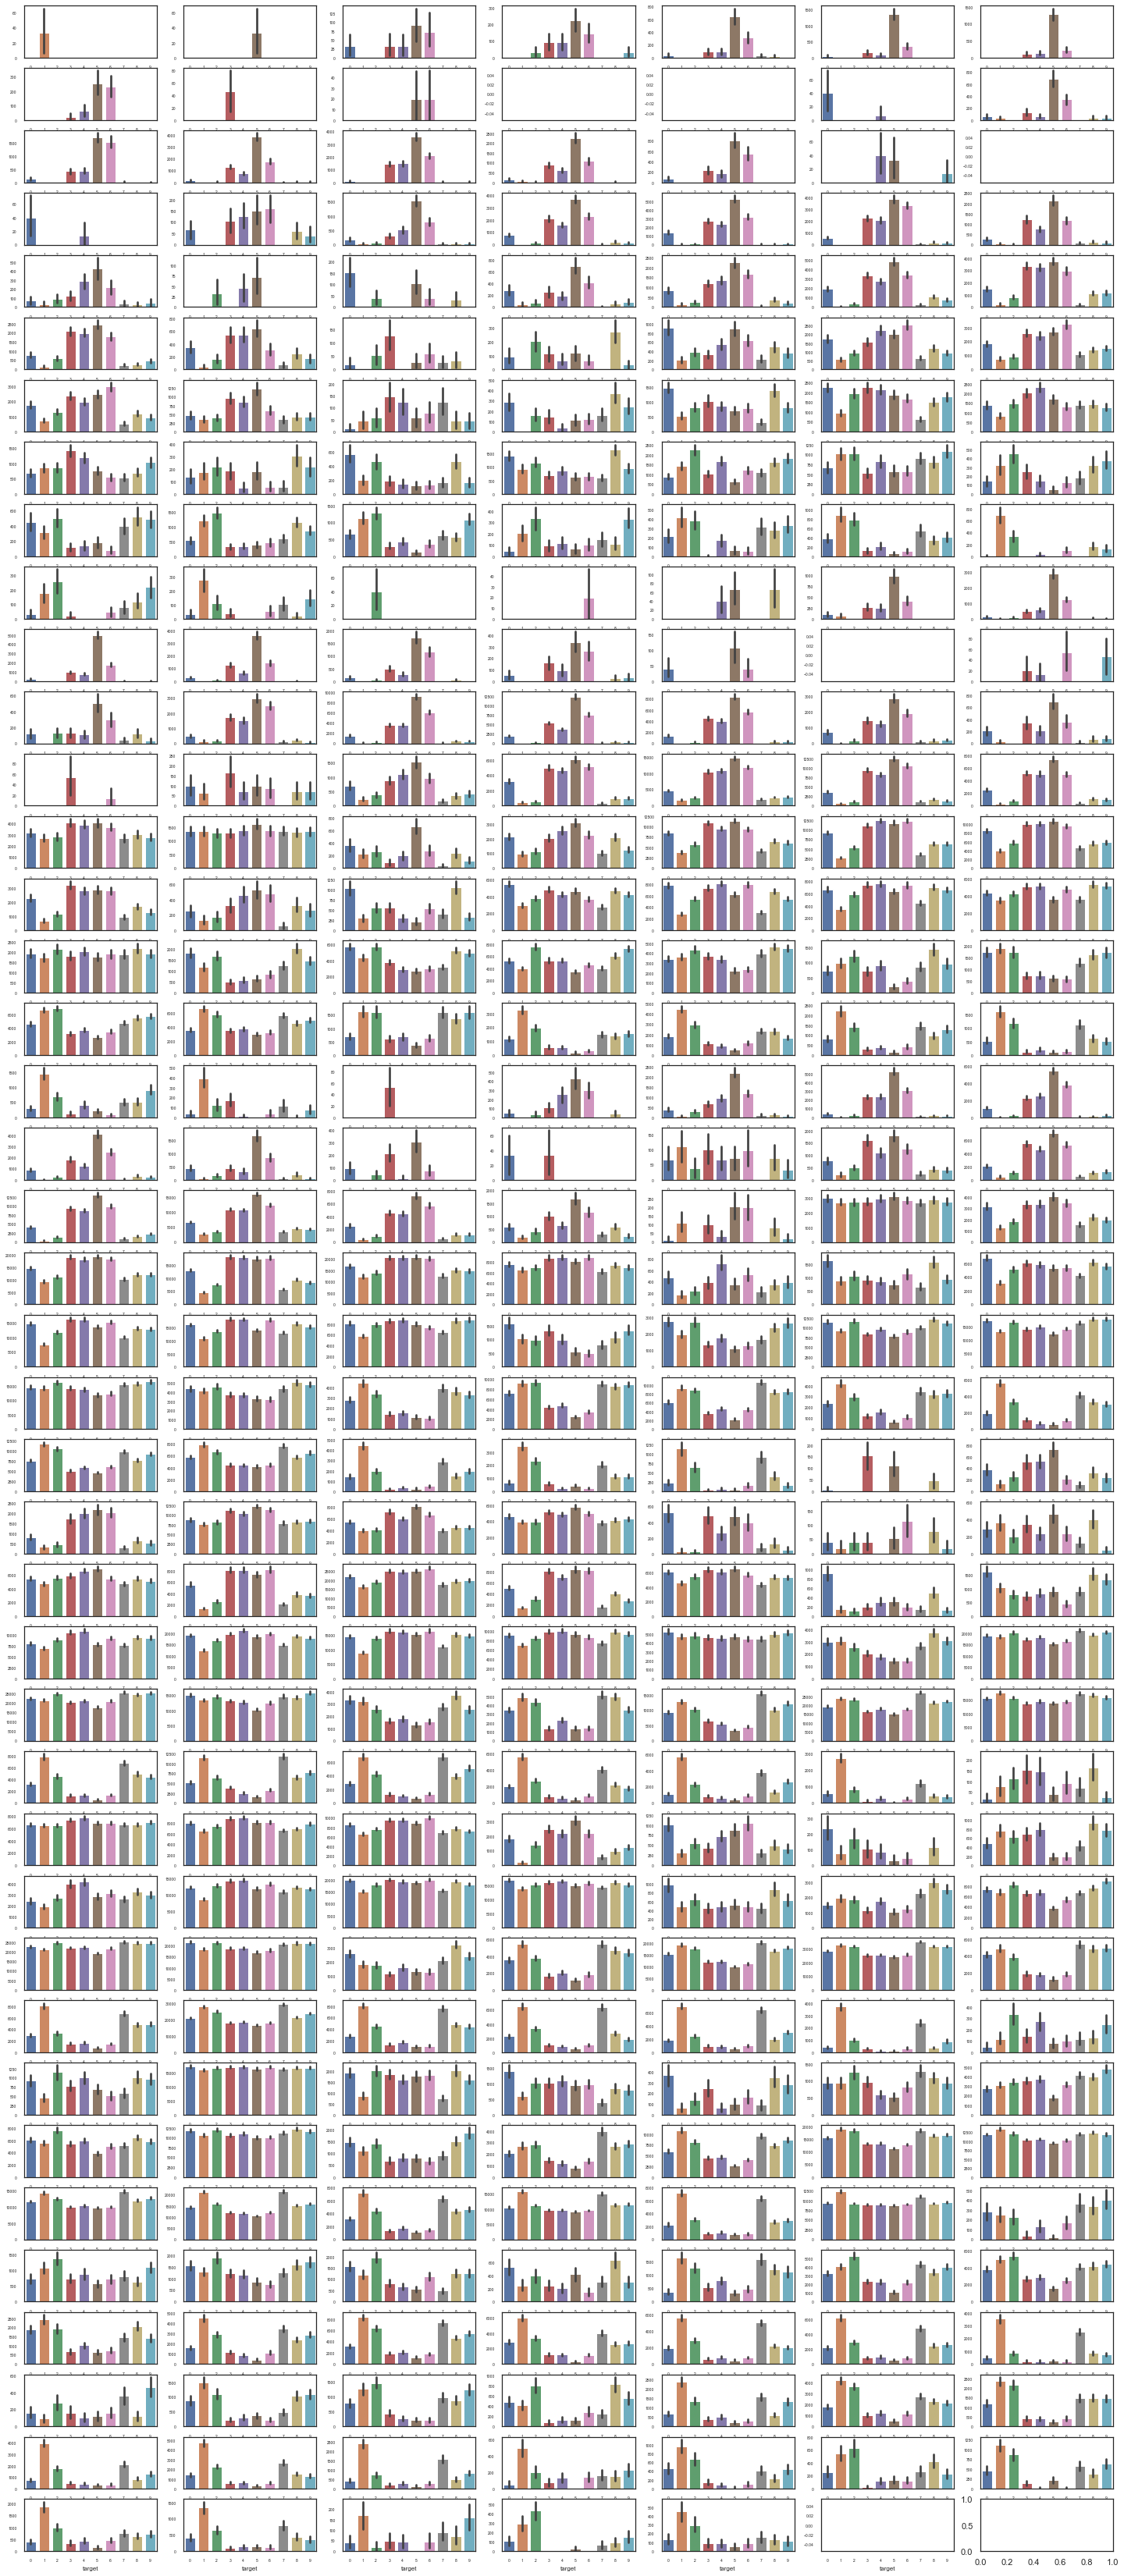

In [36]:
ncols = 7
nrows = 41
#n_features = cont_features[100:200]
fig, axes = plt.subplots(nrows, ncols, figsize=(25, 60))

for idx, feat in enumerate(FEATURES):

    r = int(idx / ncols)
    c = int(idx % ncols)

    sns.barplot(x=TARGET, y=feat, data=train_stat[f'gcd_10000'], ax=axes[r, c])
    #sns.barplot(x=TARGET, y=feat, data=train_stat[f'gcd_10000'])
    #col = n_features[r*ncols+c]
    #sns.kdeplot(x=train[col], ax=axes[r, c], color='#F8766D', label='Train data' , fill =True )
    #sns.kdeplot(x=test[col], ax=axes[r, c], color='#00BFC4', label='Test data', fill =True)
    #axes[r,c].legend()
    axes[r, c].set_ylabel('')
    axes[r, c].set_xlabel(TARGET, fontsize=8)
    axes[r, c].tick_params(labelsize=5, width=0.5)
    axes[r, c].xaxis.offsetText.set_fontsize(6)
    axes[r, c].yaxis.offsetText.set_fontsize(4)

In [37]:
train_stat[f'gcd_10000'].head(3)

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,gcd,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10000,9
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10000,2
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10000,9


## Feature Engineering
- 値を整数値へ復元
- 各行の最大公約数を算出
- 平均、分散、最大値、最小値、中央値、第一四分位数、第三四分位数、歪度、尖度を追加

In [ ]:
len(np.unique(train_df['A0T0G2C8']))

### 統計量の追加

In [ ]:
train_df["mean"] = train_df[FEATURES].mean(axis=1)
train_df["std"] = train_df[FEATURES].std(axis=1)
train_df["min"] = train_df[FEATURES].min(axis=1)
train_df["max"] = train_df[FEATURES].max(axis=1)
train_df["median"] = train_df[FEATURES].median(axis=1)
train_df["25%"] = train_df[FEATURES].quantile(q=0.25, axis=1)
train_df["75%"] = train_df[FEATURES].quantile(q=0.75, axis=1)
train_df["skew"] = train_df[FEATURES].skew(axis=1)
train_df["kurt"] = train_df[FEATURES].kurt(axis=1)

test_df["mean"] = test_df[FEATURES].mean(axis=1)
test_df["std"] = test_df[FEATURES].std(axis=1)
test_df["min"] = test_df[FEATURES].min(axis=1)
test_df["max"] = test_df[FEATURES].max(axis=1)
test_df["median"] = test_df[FEATURES].median(axis=1)
test_df["25%"] = test_df[FEATURES].quantile(q=0.25, axis=1)
test_df["75%"] = test_df[FEATURES].quantile(q=0.75, axis=1)
test_df["skew"] = test_df[FEATURES].skew(axis=1)
test_df["kurt"] = test_df[FEATURES].kurt(axis=1)

FEATURES.extend(['mean', 'std', 'min', 'max', 'median', '25%', '75%', 'skew', 'kurt', 'gcd'])

In [ ]:
train_df.head()

In [ ]:
test_df.head()

## Save dataset

In [ ]:
#train_df.to_csv(f"../data/processed/nb{NB}_train.csv")
#test_df.to_csv(f"../data/processed/nb{NB}_test.csv")
pd.to_pickle(train_df, f"../data/processed/nb{NB}_train.pkl", compression='zip')
pd.to_pickle(test_df, f"../data/processed/nb{NB}_test.pkl", compression='zip')

# 検証メモ

In [ ]:
dataset[dataset['target'] == 'Streptococcus_pyogenes'].describe()

In [ ]:
train_df[['A0T0G0C10', 'target']].groupby(['target']).max()

In [ ]:
train_df.groupby(['target']).describe(exclude='int')

In [ ]:
train_i.head()

In [ ]:
train.head()

In [ ]:
print(train.shape)
print(test.shape)

In [ ]:
train['target'].unique()

In [ ]:
train.columns

### Targetのバランス
- 結論：ほぼ均等

In [ ]:
dataset['target'].value_counts()

In [ ]:
target_df = pd.DataFrame(train['target'].value_counts()).reset_index()
target_df.columns = ['target', 'count']
target_df['percentage'] = target_df['count'] / len(train) * 100

target_df

In [ ]:
g = sns.catplot(x="count", y="target", data=target_df, kind="bar")
g = g.set_ylabels("Num of target")

## 各列の分散

In [ ]:
train_df.head()

In [ ]:
train_df.iloc[:, 1:-3].describe().T.sort_values(by='std', ascending=False)\
                     .style.background_gradient(cmap='GnBu')
#                     .bar(subset=["max"], color='#F8766D')\
#                     .bar(subset=["mean",], color='#00BFC4')

In [ ]:
bacteria_mean_df = train_df.groupby(TARGET).mean()
bacteria_std_df = train_df.groupby(TARGET).std()
#.iloc[:, 1:-3].std()
#describe().T.sort_values(by='std', ascending=False)

In [ ]:
bacteria_mean_df['A2T2G3C3']

In [ ]:
bacteria_std_df['A2T2G3C3']

In [ ]:
bacteria_mean_df.iloc[:, 1:-2].describe().T.sort_values(by='std', ascending=False).style.background_gradient(cmap='GnBu')

### 各GCDごとでstdを見る

In [ ]:
for gcd in np.unique(train_df['gcd']):
    df = train_df[train_df['gcd'] == gcd].iloc[:, 1:-3].describe().T.sort_values(by='std', ascending=False)
    display(df.head(10).style.background_gradient(cmap='GnBu'))

### 最大公約数ごとに重複量を確認する

In [ ]:
def plot_duplicates_per_gcd(df, title):
    """データの重複を確認する

    Args:
        df (dataframe): データセット
        title (string): 図のタイトル
    """
    plt.figure(figsize=(14, 3))
    plt.tight_layout()
    for i, gcd in enumerate(np.unique(df.gcd)):
        plt.subplot(1, 4, i+1)
        duplicates = df[df.gcd == gcd][FEATURES].duplicated().sum()
        non_duplicates = len(df[df.gcd == gcd]) - duplicates
        plt.pie([non_duplicates, duplicates],
                labels=['not duplicate', 'duplicate'],
                colors=['gray', 'r'],
                startangle=90)
        plt.title(f"GCD = {gcd}")
    plt.subplots_adjust(wspace=0.8)
    plt.suptitle(title)
    plt.show()

plot_duplicates_per_gcd(train_df, title="Duplicates in Training")
plot_duplicates_per_gcd(test_df, title="Duplicates in Test")

### PCAで分類を試みる

In [ ]:
for scale in np.sort(train_df['gcd'].unique()):
    # Compute the PCA
    pca = PCA(whiten=True, random_state=1)
    pca.fit(train_i[FEATURES][train_df['gcd'] == scale])

    # Transform the data so that the components can be analyzed
    Xt_tr = pca.transform(train_i[FEATURES][train_df['gcd'] == scale])
    Xt_te = pca.transform(test_i[FEATURES][test_df['gcd'] == scale])

    # Plot a scattergram, projected to two PCA components, colored by classification target
    plt.figure(figsize=(6,6))

    for tgt in range(10):
        df_tmp = train_df[train_df['gcd'] == scale].reset_index()
        idx = df_tmp[train_df['target_num'] == tgt].index
        Xt_1 = Xt_tr[idx,0]
        Xt_2 = Xt_tr[idx,1]
        plt.scatter(Xt_1, Xt_2, c=f'#{tgt}01122', label=f'{tgt}', s=1)

    plt.title(f"{1000000 // scale} decamers ({(train_df['gcd'] == scale).sum()} samples with gcd = {scale})")
    plt.legend()
    plt.show()

### 適当な２列を抽出して散布図を確認

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(train_df.iloc[:,240][train_df['gcd'] == 1],
            train_df.iloc[:,181][train_df['gcd'] == 1],
            c=train_df.target_num[train_df['gcd'] == 1], s=1)
plt.show()